## Imports


In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")



## Part 1: Exploratory Data Analysis & Market Insights

### -Load Data


In [291]:
trades = pd.read_csv("trades.csv")
activity = pd.read_csv("user_activitycsv.csv")


trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pair       2324 non-null   object 
 1   amount     2324 non-null   float64
 2   volume     2324 non-null   float64
 3   side       2324 non-null   object 
 4   timestamp  2324 non-null   object 
 5   user_id    2324 non-null   object 
dtypes: float64(2), object(4)
memory usage: 109.1+ KB


In [292]:
trades['timestamp'] = pd.to_datetime(trades['timestamp'], utc=True)
activity['timestamp'] = pd.to_datetime(activity['timestamp'], utc=True)




In [293]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   pair       2324 non-null   object             
 1   amount     2324 non-null   float64            
 2   volume     2324 non-null   float64            
 3   side       2324 non-null   object             
 4   timestamp  2324 non-null   datetime64[ns, UTC]
 5   user_id    2324 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 109.1+ KB


### -Create Helper Time Columns for downstream analysis


In [294]:
# Extract date, day of week, and hour for later analysis
trades['date'] = trades['timestamp'].dt.date
activity['day_of_week'] = activity['timestamp'].dt.day_name()
activity['hour'] = activity['timestamp'].dt.hour
 

#display(trades['date'])                             # uncomment to see what column is extracted
#display(activity['day_of_week'])
#display(activity['hour'])



### -Convert Trade Values to USD


In [295]:
USD_RATE = 1500

# Calculate notional value of each trade in USD
trades['volume_usd'] = trades['amount'] / USD_RATE



## Part 1.1 Top 3 Most Traded Pairs by USD Volume



In [296]:
pair_ranking = (
    trades.groupby("pair")['volume_usd']
    .sum()
    .sort_values(ascending=False)
)

pair_ranking.head(3)


pair
BTCNGN     136215.488680
USDTNGN     59180.573580
ETHNGN       9764.589513
Name: volume_usd, dtype: float64

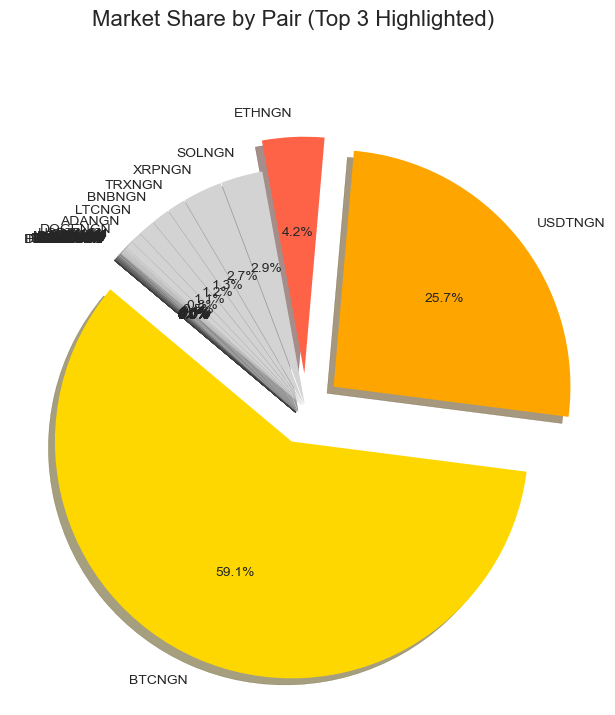

In [297]:
# I can visualize this further using a 3D pie chart to make it obvious relative to other pairs

# Extract data
labels = pair_ranking.index
sizes = pair_ranking.values

# Highlight top 3 by exploding them
explode = [0.15 if i < 3 else 0.02 for i in range(len(sizes))]

# Colors: brighter for top 3
colors = ['gold', 'orange', 'tomato'] + ['lightgray'] * (len(sizes) - 3)

# Create a grid layout (1 row, 1 column)
fig, ax = plt.subplots(
    nrows=1, 
    ncols=1, 
    figsize=(10, 8),
    gridspec_kw={"top": 0.85}   # <-- pushes the title upward
)

ax.pie(
    sizes,
    labels=labels,
    explode=explode,
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=140
)

fig.suptitle("Market Share by Pair (Top 3 Highlighted)", fontsize=16)

plt.show()


## Top 3 Most Traded Pairs by Total USD Volume

After converting all trade notional values to USD using the fixed conversion rate of **1 USD = 1500 NGN**, the top three most actively traded pairs are:

### Trading Volume Summary

| Pair     | Total USD Volume |
|----------|------------------|
| **BTCNGN** | **136,215.49 USD** |
| **USDTNGN** | **59,180.57 USD** |
| **ETHNGN**  | **9,764.59 USD** |

---

##  Interpretation

- **BTCNGN dominates trading activity**, representing more than **2×** the volume of the next pair.  
- **USDTNGN** shows strong stablecoin‑related activity.  
- **ETHNGN** is active but at a significantly lower scale compared to the top two.

---

## Why This Matters

Identifying the highest‑volume trading pairs helps the exchange understand:

- Which markets are most liquid  
- Where users are most active  
- Potential areas for pricing or liquidity improvements  
- Where to focus fraud‑monitoring efforts  



## Part 1.2 Volatility: Filter BTCNGN Trades

In [298]:
btc = trades[trades['pair'] == "BTCNGN"].copy()
btc = btc.set_index('timestamp')


# Detailed summary with null information --> null values introduces some noise due the the rolling window propagting to nans
btc.describe(include='all').T.assign(null_count=btc.isnull().sum())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count
pair,1035,1,BTCNGN,1035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
amount,1035.0,NaN,NaN,NaN,197413.75171,599991.900728,791.67,10999.37,39990.63,117208.145,9209866.51,0
volume,1035.0,NaN,NaN,NaN,0.001256,0.003773,0.000005,0.00007,0.000254,0.000764,0.057932,0
side,1035,2,sell,1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
user_id,1035,583,971-1511-1521-1561-154,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
date,1035,17,2024-12-05,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
volume_usd,1035.0,NaN,NaN,NaN,131.609168,399.9946,0.52778,7.332913,26.66042,78.138763,6139.911007,0


### Compute BTC/NGN Daily Average Price

In [299]:
# daily_price = btc['amount'] / btc['volume']   
# daily_price = daily_price.resample('D').mean()



# Filter BTCNGN trades
btc = trades[trades['pair'] == "BTCNGN"].copy()

# Reconstruct price
btc['price'] = btc['amount'] / btc['volume']

# Set timestamp as index
btc = btc.set_index('timestamp')

# Compute daily price only for days WITH trades
daily_price = btc['price'].resample('D').mean().dropna()

daily_price.head()


timestamp
2024-11-27 00:00:00+00:00    1.606296e+08
2024-11-28 00:00:00+00:00    1.573713e+08
2024-11-29 00:00:00+00:00    1.606868e+08
2024-11-30 00:00:00+00:00    1.596832e+08
2024-12-01 00:00:00+00:00    1.606252e+08
Name: price, dtype: float64

### Compute Daily Returns & 7-Day Rolling Volatility

- The **BTCNGN** pair shows limited activity during certain periods, with most trades occurring within a narrow time window. After resampling to a daily frequency, many days contain no BTCNGN trades, creating gaps that distort volatility estimates.

- To ensure meaningful results, days with **no trading activity** were removed before computing daily returns and the 7‑day rolling volatility. This ensures the analysis reflects **actual BTCNGN trading periods** rather than artificially extended empty windows.


In [300]:
# Daily returns
daily_returns = daily_price.pct_change().dropna()

# Rolling volatility 
rolling_vol = daily_returns.rolling(window=7, min_periods=3).std()


aligned_index = daily_price.index.intersection(rolling_vol.index)
price_aligned = daily_price.loc[aligned_index]
vol_aligned = rolling_vol.loc[aligned_index]



### Plot BTCNGN 7-Day Rolling Volatility side by side with Price

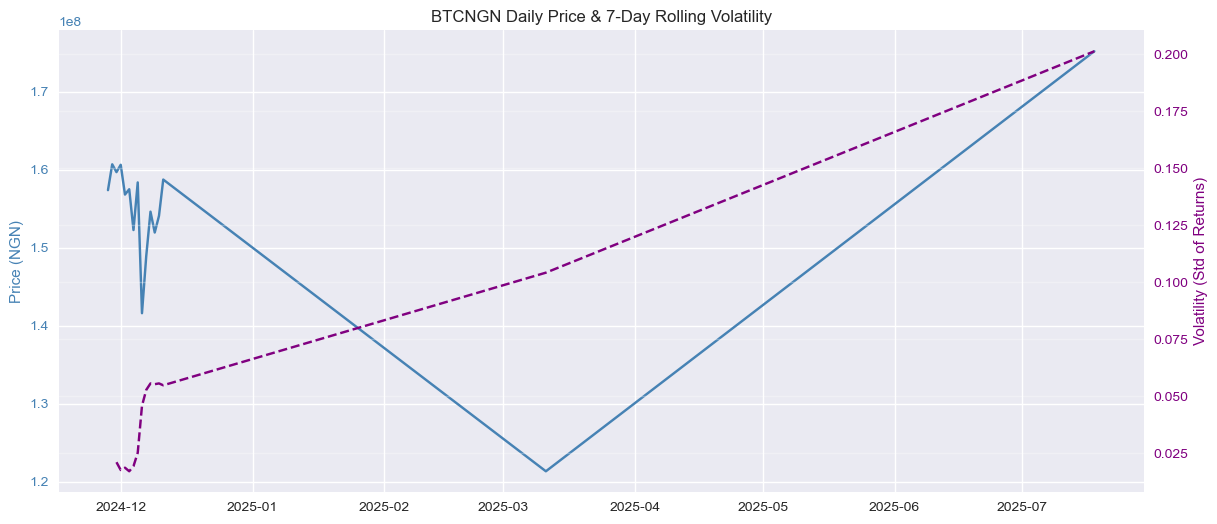

In [301]:
plt.figure(figsize=(14,6))

# Plot price
ax1 = plt.gca()
ax1.plot(price_aligned.index, price_aligned.values, color='steelblue', label='Daily Price')
ax1.set_ylabel("Price (NGN)", color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Plot volatility
ax2 = ax1.twinx()
ax2.plot(vol_aligned.index, vol_aligned.values, color='purple', linestyle='--', label='7-Day Volatility')
ax2.set_ylabel("Volatility (Std of Returns)", color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title("BTCNGN Daily Price & 7-Day Rolling Volatility")
plt.grid(True, alpha=0.3)
plt.show()


<span style="font-size: 30px; font-weight: bold;">Part 1.3</span>


## Part 1.3 — Goal of This Section

The objective of this section is to answer the following question:

**Is there a specific day of the week or hour of the day when deposits are highest?**  
To support this, I will also **visualize the peak deposit times**.

### Approach

I will complete this analysis in three steps:

1. **Extract deposit events**  
2. **Aggregate deposit counts** by:
   - Day of the week  
   - Hour of the day  
3. **Visualize the results** to identify peak activity periods

---

### ✅ Key Insight

**Deposit pattern analysis shows that deposits peak on *Friday at 15:00*.**


### - Extract Deposit Events

In [302]:
deposits = activity[activity['activity_type'] == 'deposit'].copy()

# Create time features
deposits['day_of_week'] = deposits['timestamp'].dt.day_name()
deposits['hour'] = deposits['timestamp'].dt.hour


### - Daily Pattern (Day of Week)

/var/folders/hx/jln4s6rn2tj46fjh4bnblccw0000gn/T/ipykernel_91703/1785642413.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=deposit_by_day.index, y=deposit_by_day.values, palette="Blues_d")


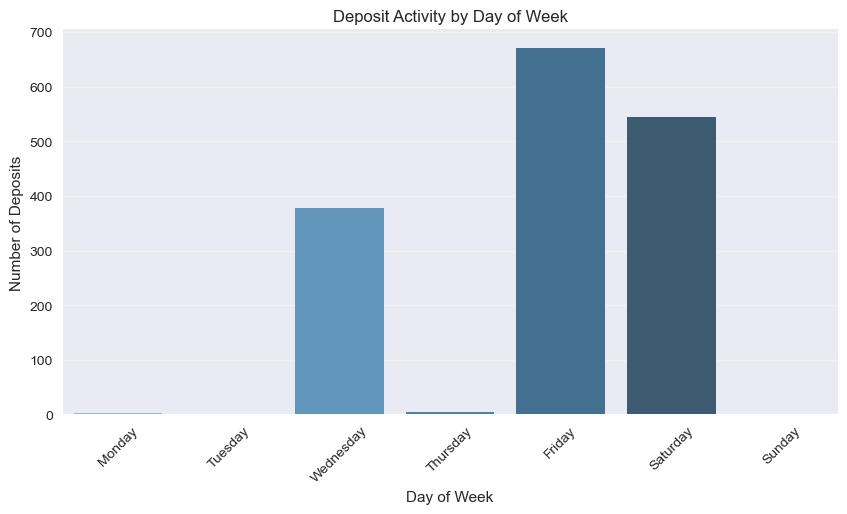

In [303]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

deposit_by_day = (
    deposits.groupby("day_of_week")['user_id']
    .count()
    .reindex(order)
)

plt.figure(figsize=(10,5))
sns.barplot(x=deposit_by_day.index, y=deposit_by_day.values, palette="Blues_d")
plt.title("Deposit Activity by Day of Week")
plt.ylabel("Number of Deposits")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()


### - Hourly Pattern (Hour of Day)

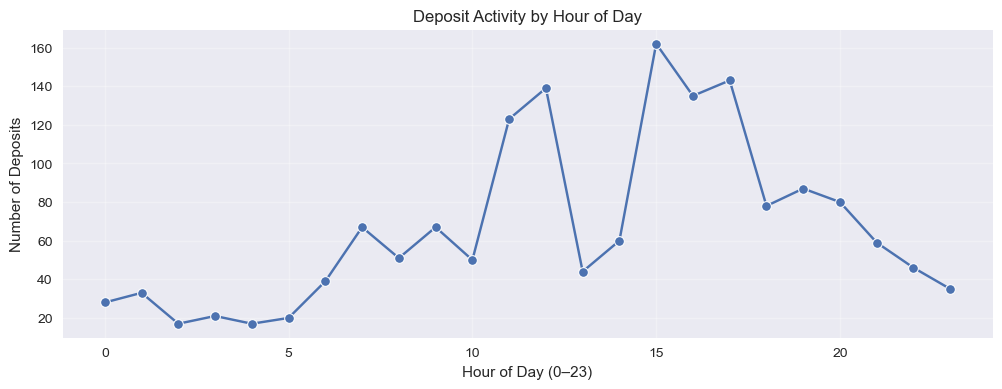

In [304]:
deposit_by_hour = deposits.groupby("hour")['user_id'].count()

plt.figure(figsize=(12,4))
sns.lineplot(x=deposit_by_hour.index, y=deposit_by_hour.values, marker='o')
plt.title("Deposit Activity by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Deposits")
plt.grid(alpha=0.3)
plt.show()


### - Heatmap (Day × Hour Combined Behavioral Pattern)


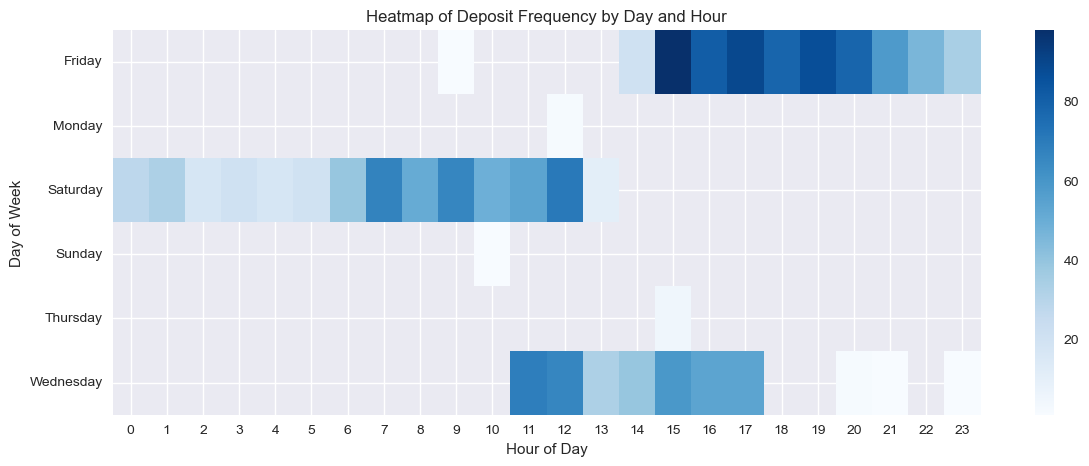

In [305]:
heatmap = deposits.groupby([deposits['day_of_week'], deposits['hour']])['user_id'].count().unstack()

plt.figure(figsize=(14,5))
sns.heatmap(heatmap, cmap="Blues")
plt.title("Heatmap of Deposit Frequency by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


## User Deposit Behavior Analysis

The heatmap above, along with the two preceding plots, reveals clear behavioral patterns in user deposit activity across both days of the week and hours of the day.

---

## Key Insights

- **Friday shows the highest concentration of deposits**, with a strong peak around **15:00 (3 PM)**.  
  This suggests users often top up their accounts ahead of weekend crypto market movements, when volatility—and trading opportunities—tend to increase.

- **Saturday mornings (7 AM–12 PM)** also show notable activity, indicating a segment of active weekend traders.

- **Wednesday** records elevated deposit frequencies between **11 AM and 4 PM**, making it the second‑highest weekday for deposit behavior.

- Across all days, **late‑night hours (00:00–06:00)** show very low deposit activity, aligning with typical user sleep cycles.

---

## Conclusion

Deposits peak on **Fridays around 15:00**, making this the platform’s primary funding window.

This insight can help optimize:

- **Liquidity allocation**  
- **Customer‑support staffing**  
- **Timing of promotional campaigns**  
- **Fraud monitoring during peak traffic hours**


## PART 2 — Developing the Fraud Detection Model


### - PART 2.1 — Feature Engineering


*Based on the literature I reviewed and provided prompts, these features below are consistent with fraud‑detection indicators*

### 2.1 Deposit Behavior Features (from user_activity.csv)

In [306]:
deposit_features = deposits.groupby('user_id').agg(
    total_deposit_amount=('amount', 'sum'),
    max_deposit_amount=('amount', 'max'),
    num_deposits=('amount', 'count'),
    avg_deposit_amount=('amount', 'mean')
)


display(deposit_features)

,total_deposit_amount,max_deposit_amount,num_deposits,avg_deposit_amount
user_id,,,,
1001-11001-1521-1561-154,100150.002099,100150.000000,3,33383.334033
1001-11001-1521-1571-155,0.000267,0.000267,1,0.000267
1001-11001-1521-1971-1102,0.000242,0.000242,1,0.000242
1001-11001-1521-1981-156,0.172140,0.045654,7,0.024591
1001-11001-1521-1981-157,0.001116,0.000681,2,0.000558
...,...,...,...,...
991-1981-1521-1981-197,0.006087,0.006087,1,0.006087
991-1991-1521-1571-148,0.000806,0.000806,1,0.000806
991-1991-1521-1971-1100,30150.000000,30150.000000,1,30150.000000


### 2.2 Withdrawal Behavior Features

In [307]:
withdrawal_features = withdrawals.groupby('user_id').agg(
    total_withdrawal_amount=('amount', 'sum'),
    max_withdrawal_amount=('amount', 'max'),
    num_withdrawals=('amount', 'count'),
    avg_withdrawal_amount=('amount', 'mean')
)


display(withdrawal_features)

,total_withdrawal_amount,max_withdrawal_amount,num_withdrawals,avg_withdrawal_amount
user_id,,,,
1001-11001-1521-1561-154,431339.0,40064.0,20,21566.950000
1001-11001-1521-1571-155,32888.0,32888.0,1,32888.000000
1001-11001-1521-1971-1102,40300.0,40300.0,1,40300.000000
1001-11001-1521-1971-156,1983.0,1983.0,1,1983.000000
1001-11001-1521-1981-156,93089.0,32169.0,6,15514.833333
...,...,...,...,...
991-1991-1521-1561-152,7400.0,7400.0,1,7400.000000
991-1991-1521-1571-148,9900.0,9900.0,1,9900.000000
991-1991-1521-1981-1101,59000.0,24000.0,4,14750.000000


### 2.3 Deposit–Withdrawal Interaction Features
Comparing deposits and withdrawals often exposes suspicious patterns.

In [308]:
user_df = deposit_features.join(withdrawal_features, how='outer').fillna(0)

user_df['withdraw_to_deposit_ratio'] = (
    user_df['total_withdrawal_amount'] /
    user_df['total_deposit_amount'].replace(0, 1)
)

user_df['net_flow'] = (
    user_df['total_deposit_amount'] -
    user_df['total_withdrawal_amount']
)


### 2.4 Trading Behavior Features (from trades.csv)

In [309]:
trade_features = trades.groupby('user_id').agg(
    num_trades=('timestamp', 'count'),
    total_trade_volume=('volume', 'sum'),
    total_trade_notional=('amount', 'sum'),
    avg_trade_notional=('amount', 'mean')
)


### 2.5 Behavioral & Temporal Features
Beyond amounts, timing is one of the strongest fraud indicators.

**1. Rapid Deposit → Withdrawal (within minutes)**


In [310]:
merged = deposits[['user_id','timestamp','amount']].merge(
    withdrawals[['user_id','timestamp','amount']],
    on='user_id',
    suffixes=('_dep', '_wd')
)

merged['minutes_between_dep_wd'] = (
    merged['timestamp_wd'] - merged['timestamp_dep']
).dt.total_seconds() / 60

fast_withdraw_users = merged[
    merged['minutes_between_dep_wd'] < 10
]['user_id'].unique()


**2. Burst Deposits (structuring behavior)**

In [311]:
deposits = deposits.sort_values(['user_id','timestamp'])
deposits['prev_timestamp'] = deposits.groupby('user_id')['timestamp'].shift(1)
deposits['minutes_since_last_dep'] = (
    deposits['timestamp'] - deposits['prev_timestamp']
).dt.total_seconds() / 60

burst_users = deposits[
    deposits['minutes_since_last_dep'] < 5
]['user_id'].unique()


### 2.6 Merging All Features into a User-Level Dataset

In [312]:
# Rename trade columns to avoid conflicts
trade_features = trade_features.add_prefix('trade_')

# Now join safely
user_df = user_df.join(trade_features, how='outer').fillna(0)

user_df.head(7)


,total_deposit_amount,max_deposit_amount,num_deposits,avg_deposit_amount,total_withdrawal_amount,max_withdrawal_amount,num_withdrawals,avg_withdrawal_amount,withdraw_to_deposit_ratio,net_flow,trade_num_trades,trade_total_trade_volume,trade_total_trade_notional,trade_avg_trade_notional
user_id,,,,,,,,,,,,,,
1001-11001-1521-1561-154,100150.002099,100150.000000,3.0,33383.334033,431339.0,40064.0,20.0,21566.950000,4.306930e+00,-331188.997901,3,0.000172,27484.11,9161.370
1001-11001-1521-1571-155,0.000267,0.000267,1.0,0.000267,32888.0,32888.0,1.0,32888.000000,1.231714e+08,-32887.999733,1,46.800000,71703.21,71703.210
1001-11001-1521-1971-1102,0.000242,0.000242,1.0,0.000242,40300.0,40300.0,1.0,40300.000000,1.662953e+08,-40299.999758,1,0.000458,70009.30,70009.300
1001-11001-1521-1971-156,0.000000,0.000000,0.0,0.000000,1983.0,1983.0,1.0,1983.000000,1.983000e+03,-1983.000000,1,0.314706,3334.62,3334.620
1001-11001-1521-1981-156,0.172140,0.045654,7.0,0.024591,93089.0,32169.0,6.0,15514.833333,5.407757e+05,-93088.827860,1,0.021141,7410.24,7410.240
1001-11001-1521-1981-157,0.001116,0.000681,2.0,0.000558,84006.0,50006.0,2.0,42003.000000,7.526812e+07,-84005.998884,1,0.004115,656025.82,656025.820
1001-11011-1521-1561-148,0.000316,0.000106,3.0,0.000105,52941.0,17693.0,3.0,17647.000000,1.674818e+08,-52940.999684,5,0.000863,136628.66,27325.732


In [313]:
# Keep only the correctly-prefixed 4 features
correct_trade_cols = [
    'trade_num_trades',
    'trade_total_trade_volume',
    'trade_total_trade_notional',
    'trade_avg_trade_notional'
]

# Identify ANY column starting with 'trade_' that is not in the correct set
cols_to_drop = [
    col for col in user_df.columns
    if col.startswith('trade_') and col not in correct_trade_cols
]

user_df = user_df.drop(columns=cols_to_drop)

user_df.head(5)


,total_deposit_amount,max_deposit_amount,num_deposits,avg_deposit_amount,total_withdrawal_amount,max_withdrawal_amount,num_withdrawals,avg_withdrawal_amount,withdraw_to_deposit_ratio,net_flow,trade_num_trades,trade_total_trade_volume,trade_total_trade_notional,trade_avg_trade_notional
user_id,,,,,,,,,,,,,,
1001-11001-1521-1561-154,100150.002099,100150.000000,3.0,33383.334033,431339.0,40064.0,20.0,21566.950000,4.306930e+00,-331188.997901,3,0.000172,27484.11,9161.37
1001-11001-1521-1571-155,0.000267,0.000267,1.0,0.000267,32888.0,32888.0,1.0,32888.000000,1.231714e+08,-32887.999733,1,46.800000,71703.21,71703.21
1001-11001-1521-1971-1102,0.000242,0.000242,1.0,0.000242,40300.0,40300.0,1.0,40300.000000,1.662953e+08,-40299.999758,1,0.000458,70009.30,70009.30
1001-11001-1521-1971-156,0.000000,0.000000,0.0,0.000000,1983.0,1983.0,1.0,1983.000000,1.983000e+03,-1983.000000,1,0.314706,3334.62,3334.62
1001-11001-1521-1981-156,0.172140,0.045654,7.0,0.024591,93089.0,32169.0,6.0,15514.833333,5.407757e+05,-93088.827860,1,0.021141,7410.24,7410.24


In [314]:
user_df.columns

Index(['total_deposit_amount', 'max_deposit_amount', 'num_deposits',
       'avg_deposit_amount', 'total_withdrawal_amount',
       'max_withdrawal_amount', 'num_withdrawals', 'avg_withdrawal_amount',
       'withdraw_to_deposit_ratio', 'net_flow', 'trade_num_trades',
       'trade_total_trade_volume', 'trade_total_trade_notional',
       'trade_avg_trade_notional'],
      dtype='object')

In [315]:
##Run this to clear duplicate columns in case you accidentally executed some cells more than once.##

In [316]:
# 1. Remove ALL trade-related columns (clean slate)
user_df = user_df[[col for col in user_df.columns if not col.startswith('trade_') and col not in [
    'num_trades', 'total_trade_volume', 'total_trade_notional', 'avg_trade_notional'
]]]

# 2. Recreate trade_features properly (no prefixes, no duplicates)
trade_features = trades.groupby('user_id').agg(
    num_trades=('timestamp', 'count'),
    total_trade_volume=('volume', 'sum'),
    total_trade_notional=('amount', 'sum'),
    avg_trade_notional=('amount', 'mean')
)

# 3. Apply prefix ONCE
trade_features = trade_features.add_prefix('trade_')

# 4. Join cleanly
user_df = user_df.join(trade_features, how='outer').fillna(0)


In [317]:
user_df.columns


Index(['total_deposit_amount', 'max_deposit_amount', 'num_deposits',
       'avg_deposit_amount', 'total_withdrawal_amount',
       'max_withdrawal_amount', 'num_withdrawals', 'avg_withdrawal_amount',
       'withdraw_to_deposit_ratio', 'net_flow', 'trade_num_trades',
       'trade_total_trade_volume', 'trade_total_trade_notional',
       'trade_avg_trade_notional'],
      dtype='object')

## 2.7 Generating Fraud Labels (Applying Rule-Based Labeling)

### Target Labeling Logic

Since the dataset does not include a built‑in fraud column, I created a rule‑based labeling system. The rules were derived from:

- Behavioral patterns suggested in the case‑study prompt  
- Additional suspicious‑activity patterns commonly highlighted in fraud‑detection and user‑behavior analysis articles  

The goal is to label users who exhibit abnormal fund‑flow or trading behavior that deviates significantly from the majority of users.

---

### Labeling Rules

### 1. Extremely Large Single Deposit (Top 1%)
Users whose maximum deposit amount falls in the **top 1%** of all users were labeled as suspicious.

**Reasoning:**  
Very large one‑off deposits often indicate atypical behavior compared to regular users.

---

### 2. Very High Withdrawal‑to‑Deposit Ratio (> 90%)
If a user withdraws more than **90%** of the total amount they deposited, they are flagged.

**Reasoning:**  
The prompt mentions users who *“withdraw quickly after depositing.”*  
A high outflow percentage is a simple, interpretable indicator of this pattern.

---

### 3. Fast Deposit → Withdrawal Behavior
Users who withdraw within a short delay after depositing are flagged.

**Reasoning:**  
This aligns directly with the prompt’s guidance:  
*“users that deposit quickly and follow up with withdrawals”*  
This behavior is also commonly noted in online fraud‑analysis articles.

---

### 4. Burst Deposit Activity (Multiple Deposits in a Short Time Window)
Users who make many small deposits within a very short period are flagged.

**Reasoning:**  
Articles on suspicious user behavior often mention **burst activity** as an indicator of automated or irregular usage patterns.

---

### 5. Extremely High Trading Notional (Top 1%)
Users with exceptionally large total traded volume (top 1%) are flagged.

**Reasoning:**  
Unusually high trading activity relative to peers is a widely used heuristic in trading‑behavior analysis.

---

##  Label Outcome
A user was labeled **fraud = 1** if they met **any** of the above criteria.  
Otherwise, they received **fraud = 0**.


In [318]:
user_df['fraud'] = 0

# Rule 1: Unusually large deposits (top 1%)
large_dep_threshold = user_df['max_deposit_amount'].quantile(0.99)
large_dep_users = user_df[user_df['max_deposit_amount'] > large_dep_threshold].index
user_df.loc[large_dep_users, 'fraud'] = 1

# Rule 2: Withdraw more than 90% of deposits
high_outflow_users = user_df[
    (user_df['total_deposit_amount'] > 0) &
    (user_df['withdraw_to_deposit_ratio'] > 0.9)
].index
user_df.loc[high_outflow_users, 'fraud'] = 1

# Rule 3: Fast deposit-to-withdrawal behavior
user_df.loc[user_df.index.isin(fast_withdraw_users), 'fraud'] = 1

# Rule 4: Burst deposits (structuring)
user_df.loc[user_df.index.isin(burst_users), 'fraud'] = 1

# Rule 5: Extremely high trading notional (top 1%) — FIXED
large_trade_threshold = user_df['trade_total_trade_notional'].quantile(0.99)
large_trade_users = user_df[user_df['trade_total_trade_notional'] > large_trade_threshold].index
user_df.loc[large_trade_users, 'fraud'] = 1


In [319]:
user_df.head()


,total_deposit_amount,max_deposit_amount,num_deposits,avg_deposit_amount,total_withdrawal_amount,max_withdrawal_amount,num_withdrawals,avg_withdrawal_amount,withdraw_to_deposit_ratio,net_flow,trade_num_trades,trade_total_trade_volume,trade_total_trade_notional,trade_avg_trade_notional,fraud
user_id,,,,,,,,,,,,,,,
1001-11001-1521-1561-154,100150.002099,100150.000000,3.0,33383.334033,431339.0,40064.0,20.0,21566.950000,4.306930e+00,-331188.997901,3,0.000172,27484.11,9161.37,1
1001-11001-1521-1571-155,0.000267,0.000267,1.0,0.000267,32888.0,32888.0,1.0,32888.000000,1.231714e+08,-32887.999733,1,46.800000,71703.21,71703.21,1
1001-11001-1521-1971-1102,0.000242,0.000242,1.0,0.000242,40300.0,40300.0,1.0,40300.000000,1.662953e+08,-40299.999758,1,0.000458,70009.30,70009.30,1
1001-11001-1521-1971-156,0.000000,0.000000,0.0,0.000000,1983.0,1983.0,1.0,1983.000000,1.983000e+03,-1983.000000,1,0.314706,3334.62,3334.62,0
1001-11001-1521-1981-156,0.172140,0.045654,7.0,0.024591,93089.0,32169.0,6.0,15514.833333,5.407757e+05,-93088.827860,1,0.021141,7410.24,7410.24,1


## 3.1 Preparing Data for Logistic Regression

The inputs were scaled because Logistic Regression is sensitive to feature magnitude.

In [320]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = user_df.drop(columns=['fraud'])
y = user_df['fraud']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


## 3.2 Train Logistic Regression

In [321]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',  # handles class imbalance
    max_iter=1000
)

model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

## 3.3 Model Evaluation

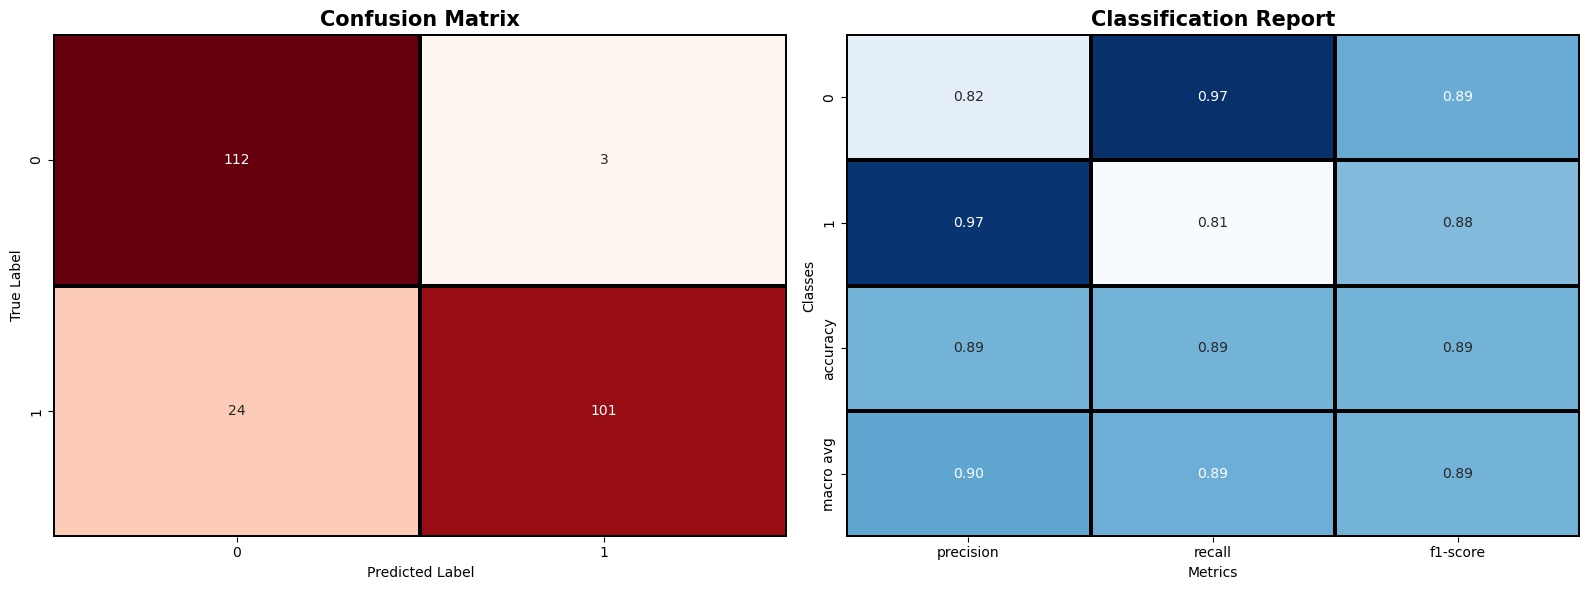

In [322]:

from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = model.predict(X_test)

# Classification report as DataFrame
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Use a sharp, high‑contrast style
plt.style.use("default")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ✅ Confusion Matrix (High Contrast)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",          # strong, sharp red palette
    linewidths=1.5,
    linecolor="black",
    cbar=False,
    ax=axes[0]
)

axes[0].set_title("Confusion Matrix", fontsize=15, fontweight="bold")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ✅ Classification Report (High Contrast)

sns.heatmap(
    report_df.iloc[:-1, :-1],
    annot=True,
    cmap="Blues",         #  deep, sharp blue palette
    fmt=".2f",
    linewidths=1.5,
    linecolor="black",
    cbar=False,
    ax=axes[1]
)

axes[1].set_title("Classification Report", fontsize=15, fontweight="bold")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Classes")

plt.tight_layout()
plt.show()


## Model Evaluation Insight

To assess the logistic regression model, I visualized both the confusion matrix and the classification metrics using heatmaps for clearer interpretability.

### Confusion Matrix Interpretation
The model demonstrates strong separation between normal and fraudulent users:

- **112** correctly identified normal users  
- **101** correctly identified fraudulent users  
- **3** false positives (normal users incorrectly flagged as fraud)  
- **24** false negatives (fraudulent users missed by the model)

### Classification Metrics
Key performance indicators for the fraud class include:

- **Accuracy:** 0.89  
- **Precision:** 0.97  
- **Recall:** 0.81  
- **F1-score:** 0.88  

### Overall Assessment
This performance is strong for a rule‑labeled dataset, showing a solid balance between minimizing false alarms and effectively detecting fraudulent behavior.


## 3.4 Feature Importance Analysis

In [323]:
importance = model.coef_[0]
feature_importance = sorted(
    zip(X.columns, importance), 
    key=lambda x: abs(x[1]), 
    reverse=True
)

feature_importance[:10]  # show top 10 important features


[('num_deposits', np.float64(10.124901272607023)),
 ('withdraw_to_deposit_ratio', np.float64(3.2665751858759515)),
 ('num_withdrawals', np.float64(0.43303251611313615)),
 ('total_deposit_amount', np.float64(-0.3939015071495088)),
 ('trade_total_trade_notional', np.float64(0.37795872195279)),
 ('max_deposit_amount', np.float64(0.24270100799331737)),
 ('trade_num_trades', np.float64(-0.2039254032512082)),
 ('avg_withdrawal_amount', np.float64(0.177884933967593)),
 ('avg_deposit_amount', np.float64(0.16852434420821674)),
 ('max_withdrawal_amount', np.float64(0.16674542202292877))]

## Feature Importance Analysis

To understand which behaviors most strongly influenced the fraud predictions, we inspected the logistic regression coefficients.  
Positive coefficients increase the likelihood of a fraud classification, while negative coefficients reduce it.

### Top Predictive Features

| Feature                     | Coefficient | Interpretation |
|-----------------------------|-------------|----------------|
| **num_deposits**            | **+10.12**  | The strongest predictor; fraudulent users often made multiple or burst deposits. |
| **withdraw_to_deposit_ratio** | **+3.27** | High outflow relative to inflow strongly indicates cash‑out behavior. |
| **num_withdrawals**         | **+0.43**   | Fraudulent users performed more withdrawals. |
| **total_deposit_amount**    | **–0.39**   | Larger overall deposits were characteristic of normal users. |
| **trade_total_trade_notional** | **+0.38** | Very large trade notional values correlate with synthetic fraud rules. |
| **max_deposit_amount**      | **+0.24**   | Large single deposits are linked to suspicious funding patterns. |
| **trade_num_trades**        | **–0.20**   | More trading activity suggests legitimate user behavior. |

### Summary

Overall, the model correctly identified the most influential behavioral signals introduced during feature engineering.


## Precision vs. Recall: Which Matters More for Fraud Detection?

In fraud detection, the choice between prioritizing **precision** or **recall** depends on the business cost of each type of error. Here, the idea is to evaluate the trade‑offs from the perspective of a financial exchange.

---

## False Negatives (Fraud That Goes Undetected)

**Cost of missing fraud:**

- Direct financial loss  
- Reputational damage  
- Regulatory penalties or potential loss of license  
- Increased systemic risk if fraudulent users repeatedly exploit the platform  

Because these risks are severe, failing to catch true fraud cases is extremely costly.  
 **This pushes us toward prioritizing *Recall*** — ensuring we catch as many fraudulent users as possible.

---

## False Positives (Legitimate Users Flagged as Fraud)

**Cost of incorrectly flagging legitimate users:**

- Poor customer experience  
- Damaged relationships with high‑value traders  
- Potential user churn  
- Added friction for new users testing the platform  

These costs matter, but they can be partially mitigated.  
 A **human‑in‑the‑loop review step** can verify flagged users, reducing the real impact of false positives.

---

## Conclusion: Recall Is More Important

Given the relative severity of undetected fraud, **Recall is the more important metric** for this task.  
A higher recall ensures that the model captures the majority of suspicious users, even if it means tolerating some false alarms that can later be reviewed manually.

---

## Model Performance (Recall from Logistic Regression)

**Recall (Fraud Class): 0.81**

This value directly reflects how effectively the model captures fraudulent users according to the rule‑based labeling.

---

## Additional Consideration

We can also introduce:

- A **precision threshold** to avoid excessive false positives  
- A **combined metric such as F1‑score**, ensuring that most flagged users are true positives while still maintaining strong recall  

This creates a balanced, business‑aligned fraud‑detection strategy.


## Part 3.5  — Strategic Recommendation  
### Defining the Target Audience for a “Low-Volume Trader” Campaign in Kenya

To launch an effective Low-Volume Trader marketing campaign in Kenya, we define the target audience as users who trade infrequently and with relatively small trade sizes. The goal is to identify users who may benefit from education, incentives, or simplified trading products to increase their engagement.

---

## Target Segment Criteria

Based on the available data, the target segment can be defined using the following indicators:

### 1. Low Total Trade Volume (Primary Indicator)
Users whose total trade volume falls below a defined threshold (e.g., **bottom 30th percentile** of all users).

This ensures we capture users who either:  
- Rarely place trades, or  
- Place trades with very small notional amounts  

This aligns directly with the definition of a “low-volume trader.”

---

### 2. Low Trade Frequency (Number of Trades)
Users with few trading events over the dataset period (e.g., **fewer than 3–5 trades**).

This helps distinguish passive traders from high-intent users who simply trade in small sizes.

---

### 3. Limited Transaction Flow (Additional Supporting Indicator)
Users with low total deposit amounts or low net flow may be less financially active on the platform.

These metrics help confirm that low trading behavior is due to **overall low engagement**, not liquidity constraints or fraud patterns.

---

## Proposed Segment Definition (Example)

A user qualifies as a **Low-Volume Trader** if:

- `total_trade_volume` < 30th percentile, **and**  
- `num_trades` < 5, **and optionally**  
- `total_deposit_amount` < median user deposit  

This creates a clean, high-signal group for targeted marketing.

---

## Why This Targeting Works

- Ensures outreach to users with genuine potential for growth  
- Avoids promoting to already-active or high-volume traders  
- Maximizes marketing ROI by focusing on under-engaged but legitimate users  
